In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ground Truth

In [26]:
import os
import json
import glob

with open('/content/drive/MyDrive/Subset/GPR1200_categoryNumber_to_text.json', 'r') as f:
    category_dict = json.load(f)

#Image Dataset
dataset = '/content/drive/MyDrive/Subset'

#Group images by category ID
category_images = {}

for imagePath in glob.glob(dataset + "/*.jpg"):
    filename = os.path.basename(imagePath)
    category_id = filename.split('_')[0]

    if category_id not in category_images:
        category_images[category_id] = []

    category_images[category_id].append(filename)

#Build Ground Truth
ground_truth = {}
for category_id, images in category_images.items():
    for image in images:
        ground_truth[image] = [img for img in images if img != image]

#for query_image, relevant_images in ground_truth.items():
    #print(f"Query: {query_image}")
    #print(f"Relevant Images: {relevant_images}")
    #print()

CBIR using Color Descriptors


Query Image:
 


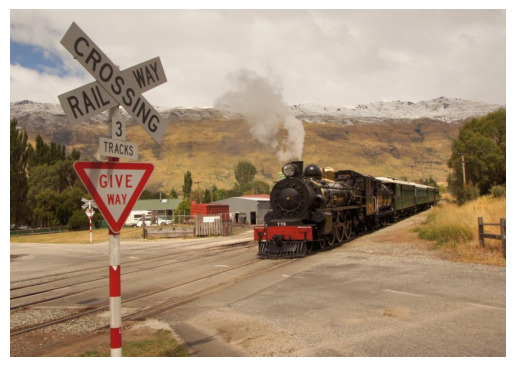


Retrieved Images:
 
Similarity Index: 0.00


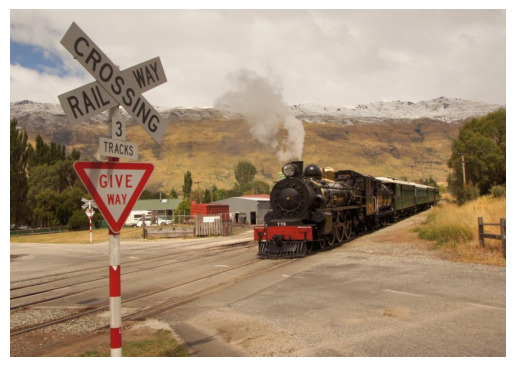

Similarity Index: 3.07


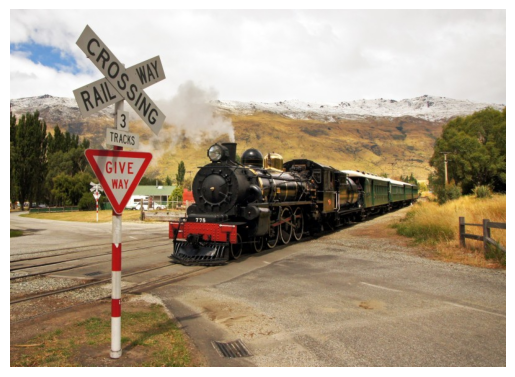

Similarity Index: 3.44


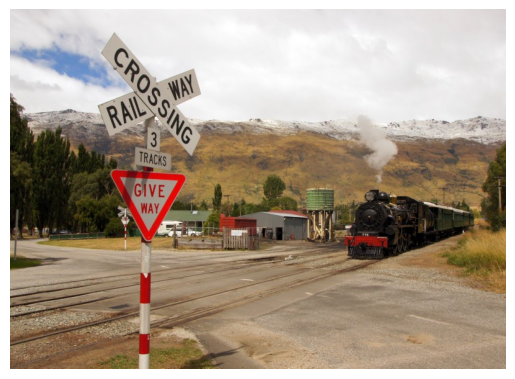

Similarity Index: 6.15


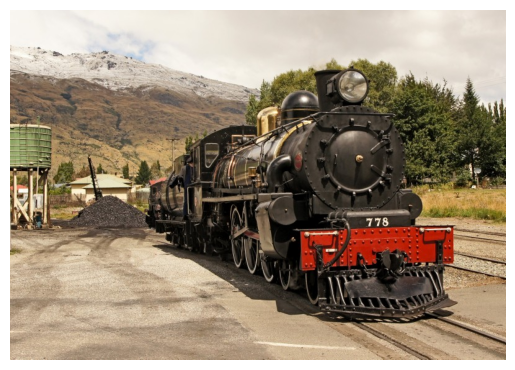

Similarity Index: 7.14


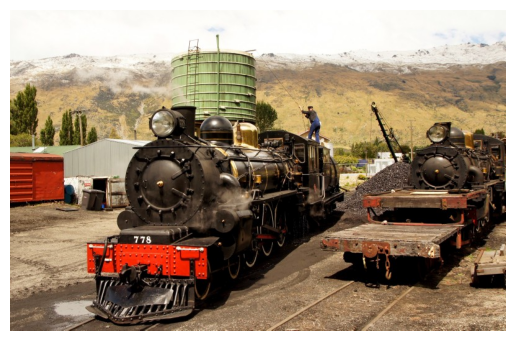


Evaluation Metrics:
Precision: 0.80


In [35]:
import cv2
import numpy as np
import csv
import glob
import os
import matplotlib.pyplot as plt
import json

#Use Color Dscriptors to Extract Features
class ColorDescriptor:
    def __init__(self, bins):
        self.bins = bins

    def describe(self, image):
        image = preprocess_image(image) #Preprocess the images
        image = image.astype('uint8')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []

        (h, w) = image.shape[:2]
        (cX, cY) = (int(w * 0.5), int(h * 0.5))
        segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h), (0, cX, cY, h)]

        (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
        ellipMask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)

        for (startX, endX, startY, endY) in segments:
            cornerMask = np.zeros(image.shape[:2], dtype="uint8")
            cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
            cornerMask = cv2.subtract(cornerMask, ellipMask)
            hist = self.histogram(image, cornerMask)
            features.extend(hist)

        hist = self.histogram(image, ellipMask)
        features.extend(hist)

        return features

    def histogram(self, image, mask):
        hist = cv2.calcHist([image], [0, 1, 2], mask, self.bins, [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        return hist

#Identify the most relevant images using similarity metric
class Searcher:
    def __init__(self, indexPath):
        self.indexPath = indexPath

    def search(self, queryFeatures):
        results = {}

        with open(self.indexPath) as f:
            reader = csv.reader(f)
            for row in reader:
                features = [float(x) for x in row[1:]]
                d = self.chi2_distance(features, queryFeatures)
                results[row[0]] = d
                #print(f"{row[0]}: {d}")

        results = sorted([(v, k) for (k, v) in results.items()])
        return results[:5]

    def chi2_distance(self, histA, histB, eps=1e-10):
        d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps) for (a, b) in zip(histA, histB)])
        return d

def preprocess_image(image):
    #Resize image
    image = cv2.resize(image, (256, 256))
    #Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image[:, :, 0] = clahe.apply(gray)
    return image

def index_images(dataset_path, index_path, bins):
    #Extract features for Query images
    cd = ColorDescriptor(bins)
    output = open(index_path, 'w')
    for imagePath in glob.glob(dataset_path + "/*.jpg"):
        imageUID = imagePath[imagePath.rfind("/") + 1:]
        image = cv2.imread(imagePath)
        features = cd.describe(image)
        features = [str(f) for f in features]
        output.write("%s,%s\n" % (imageUID, ",".join(features)))
    output.close()

def search_image(query_image_path, index_path, bins, result_path):
  #extract features for query image
    cd = ColorDescriptor(bins)
    query = cv2.imread(query_image_path)
    queryFeatures = cd.describe(query)
    searcher = Searcher(index_path)
    results = searcher.search(queryFeatures)

    return results

def show_image(image_path):
    image = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


def run():
    dataset_path = '/content/drive/MyDrive/Subset'
    index_path = '/content/drive/MyDrive/Subset/indexcolor.csv'
    query_image_path = '/content/drive/MyDrive/Subset/10_64204b5eb3156c5e.jpg'
    result_path = '/content/drive/MyDrive/Subset'
    bins = (8, 12, 3)

    #Index the dataset
    index_images(dataset_path, index_path, bins)

    #Search for similar images
    results = search_image(query_image_path, index_path, bins, result_path)
    print("\nQuery Image:\n ")
    show_image(query_image_path)

    #Display top 5 results
    print("\nRetrieved Images:\n ")
    for (score, resultID) in results:
        result_image_path = os.path.join(result_path, resultID)
        print(f"Similarity Index: {score:.2f}")
        show_image(result_image_path)


    with open('/content/drive/MyDrive/Subset/GPR1200_categoryNumber_to_text.json', 'r') as f:
        category_dict = json.load(f)

    dataset_path = '/content/drive/MyDrive/Subset'

    category_images = {}
    for imagePath in glob.glob(dataset_path + "/*.jpg"):
        filename = os.path.basename(imagePath)
        category_id = filename.split('_')[0]

        if category_id not in category_images:
            category_images[category_id] = []

        category_images[category_id].append(filename)

    ground_truth = {}
    for category_id, images in category_images.items():
        for image in images:
            ground_truth[image] = [img for img in images if img != image]

    relevant_images = ground_truth[os.path.basename(query_image_path)]
    retrieved_ids = [resultID for (score, resultID) in results]

    #Calculate precision
    relevant_retrieved = [1 if resultID in relevant_images else 0 for resultID in retrieved_ids]

    precision = np.cumsum(relevant_retrieved) / (np.arange(len(relevant_retrieved)) + 1)

    print("\nEvaluation Metrics:")
    print(f"Precision: {precision[-1]:.2f}")

run()

CBIR using Hybrid features


Query Image:



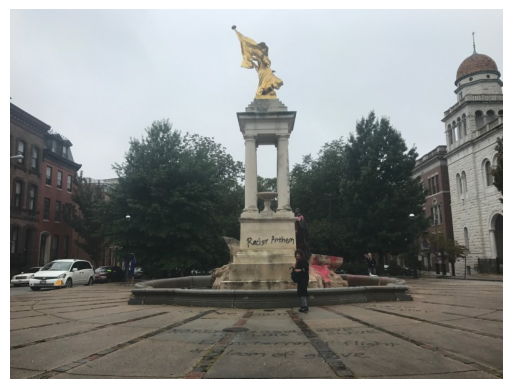


Retrieved Images:
 


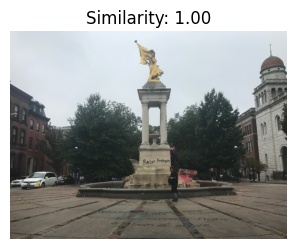

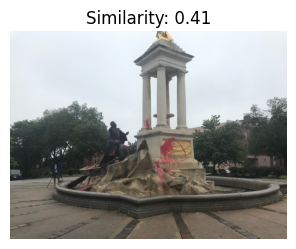

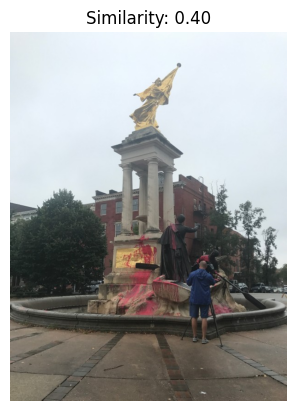

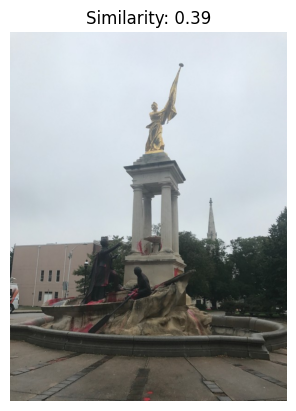

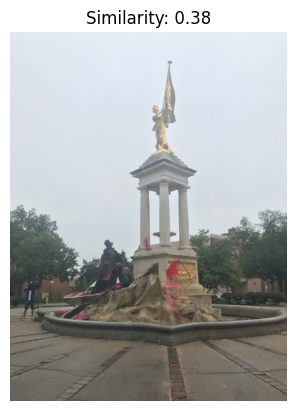


Evaluation metrics:
Precision: 0.80


In [34]:
import cv2
import numpy as np
import csv
import glob
import os
import matplotlib.pyplot as plt
import json

def preprocess_image(image):
    #Resize image
    image = cv2.resize(image, (256, 256))
    #Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image[:, :, 0] = clahe.apply(gray)
    return image

def show_image(image_path, similarity=None, position=None):
    image = cv2.imread(image_path)
    plt.figure(figsize=(25, 5))  # Increase the figure size
    if position <= 6:
        plt.subplot(1, 6, position)
    else:
        plt.figure(figsize=(25, 5))
        plt.subplot(1, 6, position % 6)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    if similarity is not None:
        plt.title(f"Similarity: {similarity:.2f}")
    plt.show()

#Extract features using ORB
class OrbDescriptor:
    def __init__(self, nfeatures=1000):
        self.orb = cv2.ORB_create(nfeatures=nfeatures)

    def describe(self, image):
        keypoints, descriptors = self.orb.detectAndCompute(image, None)
        return descriptors.flatten() if descriptors is not None else []

#Extract features using colors
class ColorDescriptor:
    def __init__(self, bins):
        self.bins = bins

    def describe(self, image):
        image = image.astype('uint8')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []

        (h, w) = image.shape[:2]
        (cX, cY) = (int(w * 0.5), int(h * 0.5))
        segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h), (0, cX, cY, h)]

        (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
        ellipMask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)

        for (startX, endX, startY, endY) in segments:
            cornerMask = np.zeros(image.shape[:2], dtype="uint8")
            cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
            cornerMask = cv2.subtract(cornerMask, ellipMask)
            hist = self.histogram(image, cornerMask)
            features.extend(hist)

        hist = self.histogram(image, ellipMask)
        features.extend(hist)

        return features

    def histogram(self, image, mask):
        hist = cv2.calcHist([image], [0, 1, 2], mask, self.bins, [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        return hist

class HybridDescriptor:
    def __init__(self, bins):
        self.orb = OrbDescriptor()
        self.color = ColorDescriptor(bins)

    def describe_orb(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return self.orb.describe(gray)

    def describe_color(self, image):
        return self.color.describe(image)

#Identify the most relevant images using similarity metric
class Searcher:
    def __init__(self, orbIndexPath, colorIndexPath):
        self.orbIndexPath = orbIndexPath
        self.colorIndexPath = colorIndexPath

    def search(self, queryFeaturesORB, queryFeaturesColor):
        results = {}

        queryDescriptors = np.array(queryFeaturesORB, dtype=np.uint8).reshape(-1, 32)

        with open(self.orbIndexPath) as f:
            reader = csv.reader(f)
            for row in reader:
                imageUID = row[0]
                features = np.array([float(x) for x in row[1:]], dtype=np.uint8)
                imageDescriptors = features.reshape(-1, 32)

                bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
                matches = bf.match(queryDescriptors, imageDescriptors)
                good = [m for m in matches if m.distance < 40]
                orb_score = len(good)
                results[imageUID] = {"orb_score": orb_score}

        orb_scores = [v["orb_score"] for v in results.values()]
        min_orb_score = min(orb_scores, default=0)
        max_orb_score = max(orb_scores, default=1)
        #print(f"ORB score range: min={min_orb_score}, max={max_orb_score}")

        for imageUID in results:
            results[imageUID]["orb_score"] = (results[imageUID]["orb_score"] - min_orb_score) / (max_orb_score - min_orb_score)
            #print(f"{imageUID} normalized ORB score: {results[imageUID]['orb_score']}")

        with open(self.colorIndexPath) as f:
            reader = csv.reader(f)
            for row in reader:
                imageUID = row[0]
                features = np.array([float(x) for x in row[1:]], dtype=np.float32)
                color_score = self.chi2_distance(queryFeaturesColor, features)
                #print(f"{imageUID} color score: {color_score}")

                if imageUID in results:
                    results[imageUID]["color_score"] = color_score
                else:
                    results[imageUID] = {"color_score": color_score}

        color_scores = [v["color_score"] for v in results.values()]
        min_color_score = min(color_scores, default=0)
        max_color_score = max(color_scores, default=1)
        #print(f"Color score range: min={min_color_score}, max={max_color_score}")

        for imageUID in results:
            results[imageUID]["color_score"] = (results[imageUID]["color_score"] - min_color_score) / (max_color_score - min_color_score)
            #print(f"{imageUID} normalized color score: {results[imageUID]['color_score']}")

        #Combine the scores
        alpha = 0.50
        beta = 0.50

        for imageUID in results:
            combined_score = alpha * results[imageUID]["orb_score"] + beta * (1 - results[imageUID]["color_score"])
            results[imageUID] = combined_score
            #print(f"{imageUID} combined score: {combined_score}")

        results = sorted([(v, k) for (k, v) in results.items()], reverse=True)
        return results[:5]

    def chi2_distance(self, histA, histB, eps=1e-10):
        d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps) for (a, b) in zip(histA, histB)])
        return d

def index_images(dataset_path, orb_index_path, color_index_path, hybrid):
   #extract features for the dataset
    with open(orb_index_path, 'w', newline='') as orb_output, open(color_index_path, 'w', newline='') as color_output:
        orb_writer = csv.writer(orb_output)
        color_writer = csv.writer(color_output)
        for imagePath in glob.glob(os.path.join(dataset_path, "*.jpg")):
            imageUID = os.path.basename(imagePath)
            image = cv2.imread(imagePath)
            image = preprocess_image(image)
            orb_features = hybrid.describe_orb(image)
            color_features = hybrid.describe_color(image)
            orb_features = [str(f) for f in orb_features]
            color_features = [str(f) for f in color_features]
            orb_writer.writerow([imageUID] + orb_features)
            color_writer.writerow([imageUID] + color_features)

def search_image(query_image_path, orb_index_path, color_index_path, hybrid, result_path):
    #extract features for the query image
    query = cv2.imread(query_image_path)
    query = preprocess_image(query)
    queryFeaturesORB = hybrid.describe_orb(query)
    queryFeaturesColor = hybrid.describe_color(query)
    searcher = Searcher(orb_index_path, color_index_path)
    results = searcher.search(queryFeaturesORB, queryFeaturesColor)

    return results

def show_image1(image_path):
    image = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


def run():
    dataset_path = '/content/drive/MyDrive/Subset'
    orb_index_path = '/content/drive/MyDrive/Subset/orb_index.csv'
    color_index_path = '/content/drive/MyDrive/Subset/color_index.csv'
    query_image_path = '/content/drive/MyDrive/Subset/3_7b3acccfce87ae42.jpg'
    result_path = '/content/drive/MyDrive/Subset'
    bins = (8, 12, 3)

    hybrid = HybridDescriptor(bins)
    index_images(dataset_path, orb_index_path, color_index_path, hybrid)
    results = search_image(query_image_path, orb_index_path, color_index_path, hybrid, result_path)

    print("\nQuery Image:\n")
    show_image1(query_image_path)

    print("\nRetrieved Images:\n ")
    position = 1
    for (similarity, resultID) in results:
        image_path = os.path.join(result_path, resultID)
        show_image(image_path, similarity, position)
        position += 1

    with open('/content/drive/MyDrive/Subset/GPR1200_categoryNumber_to_text.json', 'r') as f:
        category_dict = json.load(f)

    dataset_path = '/content/drive/MyDrive/Subset'

    category_images = {}
    for imagePath in glob.glob(dataset_path + "/*.jpg"):
        filename = os.path.basename(imagePath)
        category_id = filename.split('_')[0]

        if category_id not in category_images:
            category_images[category_id] = []

        category_images[category_id].append(filename)

    ground_truth = {}
    for category_id, images in category_images.items():
        for image in images:
            ground_truth[image] = [img for img in images if img != image]

    relevant_images = ground_truth[os.path.basename(query_image_path)]
    retrieved_ids = [resultID for (_, resultID) in results]
    #print( retrieved_ids)
    #print( relevant_images)

    #Calculate precision
    relevant_retrieved = [1 if resultID in relevant_images else 0 for resultID in retrieved_ids]
    print()
    print("Evaluation metrics:")
    precision = np.cumsum(relevant_retrieved) / (np.arange(len(relevant_retrieved)) + 1)
    print(f"Precision: {precision[-1]:.2f}")



if __name__ == "__main__":
    run()

Pretrained CNN

1/1 [==============================] - 1s 529ms/step

Query Image:
 


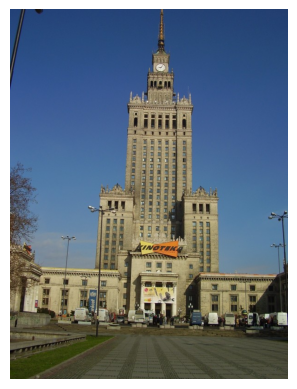


Retrieved Images:
 
Similarity Index: 1.000000099954397


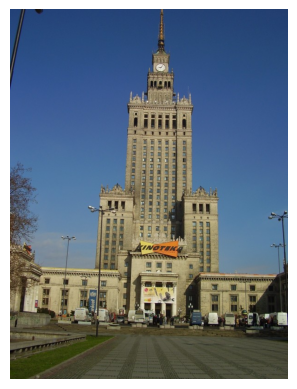

Similarity Index: 0.3152203610281279


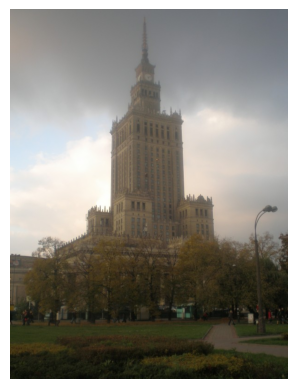

Similarity Index: 0.26908986981468175


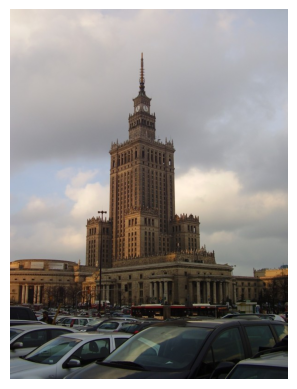

Similarity Index: 0.2588959572371473


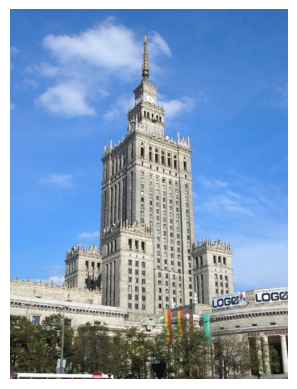

Similarity Index: 0.24796175015670868


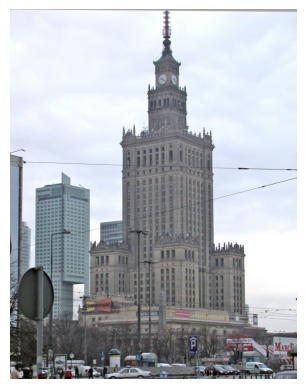


Evaluation metrics:
Precision: 0.80


In [32]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import csv
import glob
import os
import matplotlib.pyplot as plt

#Use CNN to Extract Features
class CNNDescriptor:
    def __init__(self):
        base_model = VGG16(weights='imagenet', include_top=False) #using a pretarined CNN
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_conv3').output)

    def describe(self, image):
        img = preprocess_input(image)
        img = tf.image.resize(img, (224, 224))
        img = np.expand_dims(img, axis=0)
        features = self.model.predict(img)
        features = features.flatten()
        return features

#Identify the most relevant images using similarity metric
class Searcher:
    def __init__(self, indexPath):
        self.indexPath = indexPath

    def search(self, queryFeatures):
        results = {}

        with open(self.indexPath) as f:
            reader = csv.reader(f)
            for row in reader:
                features = [float(x) for x in row[1:]]
                similarity = self.cosine_similarity(features, queryFeatures)  # Use cosine similarity
                results[row[0]] = similarity

        results = sorted([(v, k) for (k, v) in results.items()], reverse=True)  # Sort in descending order of similarity
        return results[:5]

    #cosine simialrity
    def cosine_similarity(self, vec1, vec2):
        dot_product = np.dot(vec1, vec2)
        norm_vec1 = np.linalg.norm(vec1)
        norm_vec2 = np.linalg.norm(vec2)
        return dot_product / (norm_vec1 * norm_vec2)

def index_images(dataset_path, index_path):
    #extract features for dataset
    cnn = CNNDescriptor()
    output = open(index_path, 'w')
    for imagePath in glob.glob(dataset_path + "/*.jpg"):
        imageUID = imagePath[imagePath.rfind("/") + 1:]
        image = tf.keras.preprocessing.image.load_img(imagePath, target_size=(224, 224))
        image = tf.keras.preprocessing.image.img_to_array(image)
        features = cnn.describe(image)
        features = [str(f) for f in features]
        output.write("%s,%s\n" % (imageUID, ",".join(features)))
    output.close()


def search_image(query_image_path, index_path):
    #extract features for the query images
    cnn = CNNDescriptor()
    query = tf.keras.preprocessing.image.load_img(query_image_path, target_size=(224, 224))
    query = tf.keras.preprocessing.image.img_to_array(query)
    queryFeatures = cnn.describe(query)
    searcher = Searcher(index_path)
    results = searcher.search(queryFeatures)
    return results

def show_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def calculate_precision(results, ground_truth, query_image_path):
    retrieved_ids = [resultID for (_, resultID) in results]
    relevant_images = ground_truth[os.path.basename(query_image_path)]

    true_positives = len([result for result in retrieved_ids if result in relevant_images])
    false_positives = len([result for result in retrieved_ids if result not in relevant_images])

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0

    return precision

def load_ground_truth(dataset_path):
    category_images = {}

    for imagePath in glob.glob(dataset_path + "/*.jpg"):
        filename = os.path.basename(imagePath)
        category_id = filename.split('_')[0]

        if category_id not in category_images:
            category_images[category_id] = []

        category_images[category_id].append(filename)

    ground_truth = {}

    for category_id, images in category_images.items():
        for image in images:
            ground_truth[image] = [img for img in images if img != image]

    return ground_truth

def run():
    dataset_path = '/content/drive/MyDrive/Subset'
    index_path = '/content/drive/MyDrive/Subset/indexvgg.csv'
    query_image_path = '/content/drive/MyDrive/Subset/8_2473e7146963e4df.jpg'

    index_images(dataset_path, index_path)

    results = search_image(query_image_path, index_path)

    ground_truth = load_ground_truth(dataset_path)

    #Calculate precision
    precision = calculate_precision(results, ground_truth, query_image_path)
    print("\nQuery Image:\n ")
    show_image(query_image_path)

    #Display top 5 results
    print("\nRetrieved Images:\n ")
    for (score, resultID) in results:
        result_image_path = os.path.join(dataset_path, resultID)
        print(f"Similarity Index: {score}")
        show_image(result_image_path)

    print()
    print("Evaluation metrics:")
    print(f"Precision: {precision:.2f}")


run()
